In [1]:
from bs4 import BeautifulSoup
import requests
import time
from random import randint
from IPython.core.display import clear_output
from warnings import warn

pages = [str(i) for i in range(1, 5)]
years_url = [str(i) for i in range(2011, 2019)]

names = []
years = []
imdb_ratings = []
metascores = []
votes = []

start_time = time.time()
reqs = 0

# for every year in the interval 2011-2018
for year_url in years_url:
    for page in pages:
        source = requests.get(f'http://www.imdb.com/search/title?release_date={year_url}&sort=num_votes,desc&page={page}')

        time.sleep(randint(6, 12))

        reqs += 1
        elapsed_time = time.time() - start_time
        print(f'Requests: {reqs}; Frequency: {reqs/elapsed_time}')
        clear_output(wait=True)

        # throw a warning for non 200 code
        if source.status_code != 200:
            warn(f'Request: {reqs}; Status code: {source.status_code}')

        # break if num of reqs is greater than expected
            if reqs > 72:
                warn('Number of requestes was greater than expected.')
                break

        html_soup = BeautifulSoup(source.text, 'lxml')

        movie_containers = html_soup.find_all('div', class_='lister-item mode-advanced')

        for container in movie_containers:
            if container.find('div', class_='ratings-metascore') is not None:
                name = container.h3.a.text
                names.append(name)

                year = container.h3.find('span', class_='lister-item-year').text
                years.append(year)

                imdb = float(container.strong.text)
                imdb_ratings.append(imdb)

                m_score = container.find('span', class_='metascore').text
                metascores.append(int(m_score))

                vote = container.find('span', attrs={'name':'nv'})['data-value']
                votes.append(int(vote))

Requests: 32; Frequency: 0.09639800190262798


In [3]:
import pandas as pd


movie_ratings_df = pd.DataFrame({'movie': names,
                                 'year': years,
                                 'imdb': imdb_ratings,
                                 'metascore': metascores,
                                 'votes': votes})

print(movie_ratings_df.info())
movie_ratings_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444 entries, 0 to 1443
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   movie      1444 non-null   object 
 1   year       1444 non-null   object 
 2   imdb       1444 non-null   float64
 3   metascore  1444 non-null   int64  
 4   votes      1444 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 56.5+ KB
None


In [4]:
movie_ratings_df = movie_ratings_df[['movie', 'year', 'imdb', 'metascore', 'votes']]
movie_ratings_df.head()

,movie,year,imdb,metascore,votes
0,Harry Potter and the Deathly Hallows: Part 2,(2011),8.1,85,755671
1,Untouchable,(2011),8.5,57,749716
2,Thor,(2011),7.0,57,740266
3,Captain America: The First Avenger,(2011),6.9,66,733079
4,X: First Class,(2011),7.7,65,642219


In [7]:
# clean up data for the year
movie_ratings_df['year'].unique()
movie_ratings_df.loc[:, 'year'] = movie_ratings_df['year'].str[-5:-1].astype(int)

In [8]:
movie_ratings_df['year'].head(3)



0    2011
1    2011
2    2011
Name: year, dtype: int64

In [11]:
# check for the max and the min to see that there are no unexpected outliers
movie_ratings_df.describe().loc[['min', 'max'], ['imdb', 'metascore']]

,imdb,metascore
min,4.1,27.0
max,8.6,100.0


In [13]:
# normalise imdb so both are on the same scale
movie_ratings_df['n_imdb'] = movie_ratings_df['imdb'] * 10
movie_ratings_df.head()


,movie,year,imdb,metascore,votes,n_imdb
0,Harry Potter and the Deathly Hallows: Part 2,2011,8.1,85,755671,81.0
1,Untouchable,2011,8.5,57,749716,85.0
2,Thor,2011,7.0,57,740266,70.0
3,Captain America: The First Avenger,2011,6.9,66,733079,69.0
4,X: First Class,2011,7.7,65,642219,77.0


In [16]:
# save data as csv
movie_ratings_df.to_csv('./movie_ratings_df.csv')


No handles with labels found to put in legend.


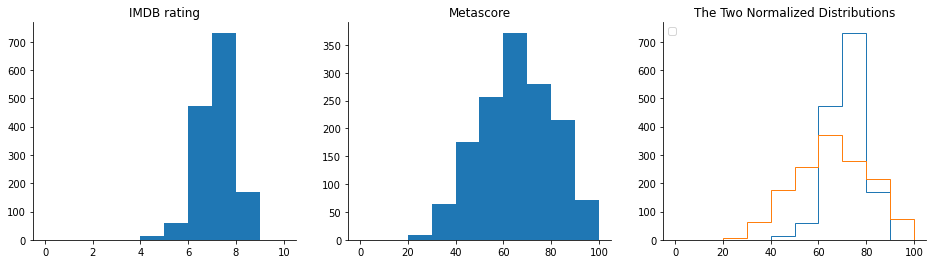

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax1, ax2, ax3 = fig.axes
ax1.hist(movie_ratings_df['imdb'], bins = 10, range = (0,10))
ax1.set_title('IMDB rating')
ax2.hist(movie_ratings_df['metascore'], bins = 10, range = (0,100))
ax2.set_title('Metascore')
ax3.hist(movie_ratings_df['n_imdb'], bins = 10, range = (0,100), histtype = 'step')
ax3.hist(movie_ratings_df['metascore'], bins = 10, range = (0,100), histtype = 'step')
ax3.legend(loc = 'upper left')
ax3.set_title('The Two Normalized Distributions')
for ax in fig.axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()